<a href="https://colab.research.google.com/github/Untick/IrisID_gr2/blob/Ruslan-Kuzminov-folder/Ruslan-Kuzminov-folder/identification_5_week_local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Идентификация по сетчатке

### **5 неделя**

**Задачи:**
- пробуем применить PyTorch Lightning Bolts, алгоритм YOLO classification (v.3, v.4, v.7)


### Подключение библиотек

In [ ]:
# импортируем необходимые для работы библиотеки

import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from pytorch_lightning import LightningModule, Trainer
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.functional import accuracy

import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance

import os
#import gdown

from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, SpatialDropout2D, BatchNormalization, MaxPooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
import pytorch_lightning as pl
from sklearn.preprocessing import LabelEncoder

import cv2
#from google.colab.patches import cv2_imshow

import random
import math

import tqdm as tq

from sklearn.model_selection import train_test_split

#from google.colab import drive

ImportError: cannot import name 'Accuracy' from 'torchmetrics.functional' (/Users/ruslankuzminov/anaconda3/lib/python3.10/site-packages/torchmetrics/functional/__init__.py)

### Загрузка данных

In [ ]:
# проверяем содержимое папки

IMAGE_TRAIN_PATH = 'images_train' # изображения тренировочной выборки
IMAGE_VALID_PATH = 'images_valid' # изображения валидационной выборки
IMAGE_TEST_PATH = 'images_test' # изображения тестовой выборки

IMAGE_FILES_TRAIN = sorted(os.listdir(IMAGE_TRAIN_PATH))
IMAGE_FILES_VALID = sorted(os.listdir(IMAGE_VALID_PATH))
IMAGE_FILES_TEST = sorted(os.listdir(IMAGE_TEST_PATH))

print(IMAGE_FILES_TRAIN[:5])
print(IMAGE_FILES_VALID[:5])
print(IMAGE_FILES_TEST[:5])

['001L_1.png', '001R_1.png', '002L_1.png', '002R_1.png', '003L_1.png']
['001L_2.png', '001R_2.png', '002L_2.png', '002R_2.png', '003L_2.png']
['001L_3.png', '001R_3.png', '002L_3.png', '002R_3.png', '003L_3.png']


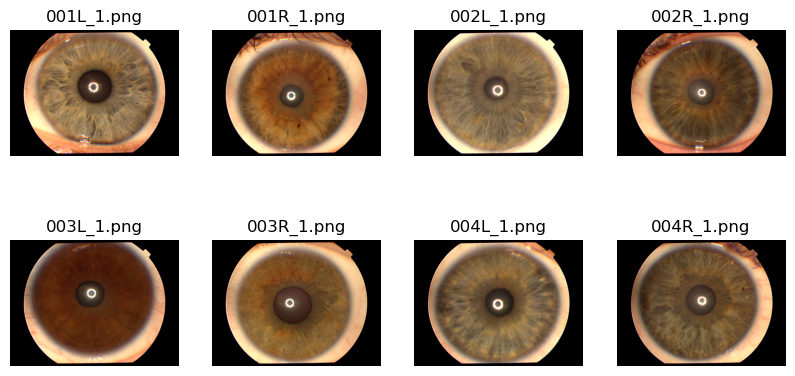

In [ ]:
# выводим серию оригинальных случайных изображений на экран

fig = plt.figure(figsize=(10,5))

for i in range(len(IMAGE_FILES_TRAIN)):
    dirs_path = f'{IMAGE_TRAIN_PATH}/'
    img_path = dirs_path + random.choice(os.listdir(dirs_path))
    ax = fig.add_subplot(2, 4, i + 1)
    ax.set_title(IMAGE_FILES_TRAIN[i])
    ax.imshow(Image.open(img_path)) # применяем функцию обрезки изображения
    ax.axis('off')
    if i == 7: # остановить добавление изображений после 8
        break

plt.show()

In [ ]:
# создаем функцию обрезки изображения

def crop_circular_image(image_path):
    # Загрузка изображения
    image = cv2.imread(image_path)

    # Конвертация из BGR в RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Получение размеров изображения
    height, width, _ = image.shape

    # Создание круглой маски
    mask = np.zeros((height, width), np.uint8)
    center = (width // 2, height // 2)
    radius = int(min(width, height) // 2.025)
    cv2.circle(mask, center, radius, (255, 255, 255), -1)

    # Применение маски к изображению
    circular_image = cv2.bitwise_and(image, image, mask=mask)

    # Вычисление координат верхнего левого угла прямоугольника
    x = int((width - min(width, height)) // 2.1)
    y = int((height - min(width, height)) // 2)

    # Вырезание прямоугольной области из изображения
    cropped_image = circular_image[y:y + min(width, height), x:x + min(width, height)]

    return cropped_image

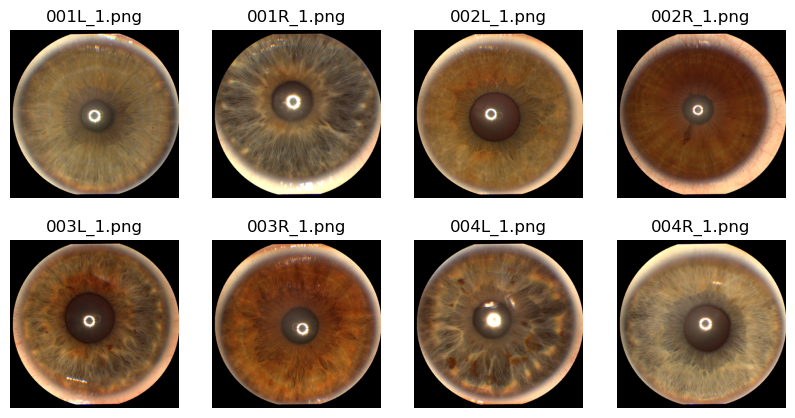

In [ ]:
# выводим серию случайных обрезанных изображений на экран

fig = plt.figure(figsize=(10,5))

for i in range(len(IMAGE_FILES_TRAIN)):
    dirs_path = f'{IMAGE_TRAIN_PATH}/'
    img_path = dirs_path + random.choice(os.listdir(dirs_path))
    ax = fig.add_subplot(2, 4, i + 1)
    ax.set_title(IMAGE_FILES_TRAIN[i])
    ax.imshow(crop_circular_image(img_path)) # применяем функцию обрезки изображения
    ax.axis('off')
    if i == 7: # остановить добавление изображений после 8
        break

plt.show()

In [ ]:
# формируем списки для картинок и меток
labels_train = []
full_names_train = []

    
# Цикл по всем файлам в текущей директории
for files in IMAGE_FILES_TRAIN:
  # Чтение изображения
  image = Image.open(os.path.join(IMAGE_TRAIN_PATH, files))
  # Добавление метки в список меток текущей папки
  label = os.path.splitext(files)[0]  # Получаем имя файла без расширения
  full_names_train.append(label)
  label = label[:-2]# модифицируем имя файла
# label = label.replace('R', '1').replace('L', '0') # заменяем для последующей работы с классами
  labels_train.append(label)

labels_valid = []
full_names_valid = []

# Цикл по всем файлам в текущей директории
for files in IMAGE_FILES_VALID:
  # Чтение изображения
  image = Image.open(os.path.join(IMAGE_VALID_PATH, files))
  # Добавление метки в список меток текущей папки
  label = os.path.splitext(files)[0]  # Получаем имя файла без расширения
  full_names_valid.append(label)
  label = label[:-2]# модифицируем имя файла
# label = label.replace('R', '1').replace('L', '0') # заменяем для последующей работы с классами
  labels_valid.append(label)

# формируем списки для тестовой выборки

labels_test = []
full_names_test = []

# Цикл по всем файлам в текущей директории
for files in IMAGE_FILES_TEST:
  # Чтение изображения
  image = Image.open(os.path.join(IMAGE_TEST_PATH, files))
  # Добавление метки в список меток текущей папки
  label = os.path.splitext(files)[0]  # Получаем имя файла без расширения
  full_names_test.append(label)
  label = label[:-2]# модифицируем имя файла
# label = label.replace('R', '1').replace('L', '0') # заменяем для последующей работы с классами
  labels_test.append(label)



# Вывод количества изображений и меток
print(f'Найдено {len(os.listdir(IMAGE_TRAIN_PATH))} изображений, {len(labels_train)} меток и {len(full_names_train)} названий для тренировочной выборки')
print(f'Найдено {len(os.listdir(IMAGE_VALID_PATH))} изображений, {len(labels_valid)} меток и {len(full_names_valid)} названий для валидационной выборки')
print(f'Найдено {len(os.listdir(IMAGE_TEST_PATH))} изображений, {len(labels_test)} меток и {len(full_names_test)} названий для тестовой выборки')


# Вывод размера изображения
image = Image.open(os.path.join(IMAGE_TRAIN_PATH, os.listdir(IMAGE_TRAIN_PATH)[0]))
img_size = image.size
print(f'Размер изображения: {img_size}')

Найдено 128 изображений, 128 меток и 128 названий для тренировочной выборки
Найдено 128 изображений, 128 меток и 128 названий для валидационной выборки
Найдено 128 изображений, 128 меток и 128 названий для тестовой выборки
Размер изображения: (768, 576)


In [ ]:
# формируем список классов

CLASSES_TRAIN = labels_train
CLASSES_VALID = labels_valid
CLASSES_TEST = labels_test

print(f'Пример названий классов тренировочной выборки: {CLASSES_TRAIN[0:10]}')
print(f'Пример названий классов валидационной выборки: {CLASSES_VALID[0:10]}')
print(f'Пример названий классов тестовой выборки: {CLASSES_TEST[0:10]}')

Пример названий классов тренировочной выборки: ['001L', '001R', '002L', '002R', '003L', '003R', '004L', '004R', '005L', '005R']
Пример названий классов валидационной выборки: ['001L', '001R', '002L', '002R', '003L', '003R', '004L', '004R', '005L', '005R']
Пример названий классов тестовой выборки: ['001L', '001R', '002L', '002R', '003L', '003R', '004L', '004R', '005L', '005R']


In [ ]:
# создаем список классов для подмены

CLASSES_TRAIN_NEW = np.array(range(1, len(CLASSES_TRAIN)+1))
CLASSES_VALID_NEW = np.array(range(1, len(CLASSES_VALID)+1))
CLASSES_TEST_NEW = np.array(range(1, len(CLASSES_TEST)+1))


# заменяем значения меток на новые классы

labels_train_changed = np.where(np.isin(labels_train, CLASSES_TRAIN), CLASSES_TRAIN_NEW[np.searchsorted(CLASSES_TRAIN, labels_train)], labels_train)
labels_valid_changed = np.where(np.isin(labels_valid, CLASSES_VALID), CLASSES_VALID_NEW[np.searchsorted(CLASSES_VALID, labels_valid)], labels_valid)
labels_test_changed = np.where(np.isin(labels_test, CLASSES_TEST), CLASSES_TEST_NEW[np.searchsorted(CLASSES_TEST, labels_test)], labels_test)

# выводим результаты
print('Тренировочная выборка:')
print("Список классов: ", CLASSES_TRAIN[0:10])
print("Массив меток: ", labels_train[0:10])
print("Измененный массив меток: ", labels_train_changed[0:10])
print("Количество классов: ", len(CLASSES_TRAIN_NEW))

print('\nВалидационная выборка:')
print("Список классов: ", CLASSES_VALID[0:10])
print("Массив меток: ", labels_valid[0:10])
print("Измененный массив меток: ", labels_valid_changed[0:10])
print("Количество классов: ", len(CLASSES_VALID_NEW))

print('\nТестовая выборка:')
print("Список классов: ", CLASSES_TEST[0:10])
print("Массив меток: ", labels_test[0:10])
print("Измененный массив меток: ", labels_test_changed[0:10])
print("Количество классов: ", len(CLASSES_TEST_NEW))

Тренировочная выборка:
Список классов:  ['001L', '001R', '002L', '002R', '003L', '003R', '004L', '004R', '005L', '005R']
Массив меток:  ['001L', '001R', '002L', '002R', '003L', '003R', '004L', '004R', '005L', '005R']
Измененный массив меток:  ['1' '2' '3' '4' '5' '6' '7' '8' '9' '10']
Количество классов:  128

Валидационная выборка:
Список классов:  ['001L', '001R', '002L', '002R', '003L', '003R', '004L', '004R', '005L', '005R']
Массив меток:  ['001L', '001R', '002L', '002R', '003L', '003R', '004L', '004R', '005L', '005R']
Измененный массив меток:  ['1' '2' '3' '4' '5' '6' '7' '8' '9' '10']
Количество классов:  128

Тестовая выборка:
Список классов:  ['001L', '001R', '002L', '002R', '003L', '003R', '004L', '004R', '005L', '005R']
Массив меток:  ['001L', '001R', '002L', '002R', '003L', '003R', '004L', '004R', '005L', '005R']
Измененный массив меток:  ['1' '2' '3' '4' '5' '6' '7' '8' '9' '10']
Количество классов:  128


### Подготовка датасета к обучению

In [ ]:
# Задаем высоту и ширину изображений

IMG_HEIGHT = int(img_size[1] / 2.5)
IMG_WIDTH = int(img_size[0] / 2.5)

size = (IMG_HEIGHT, IMG_WIDTH)

print(f'Целевой размер изображений: {size}')

Целевой размер изображений: (230, 307)


In [ ]:
# приобразуем метки в int

encoder = LabelEncoder()
labels_train_changed = encoder.fit_transform(labels_train_changed)
labels_valid_changed = encoder.fit_transform(labels_valid_changed)
labels_test_changed = encoder.fit_transform(labels_test_changed)

In [ ]:
# Пустой список для изображений тренировочной выборки
data_images = []

for filename in tq.tqdm(os.listdir(IMAGE_TRAIN_PATH)):
    # Открытие и смена размера изображения
    img_path = os.path.join(IMAGE_TRAIN_PATH, filename)
    img = Image.open(img_path).resize((IMG_WIDTH, IMG_HEIGHT))#.convert('L')
    img_np = np.array(img)                # Перевод в numpy-массив
    data_images.append(img_np)            # Добавление изображения в виде numpy-массива к общему списку

# Перевод общего списка изображений в PyTorch-тензор
# Используется np.transpose для смены порядка размерностей на (N, C, H, W)
x_train_data = torch.from_numpy(np.array(data_images).transpose((0, 3, 1, 2)))

# Перевод общего списка меток класса в PyTorch-тензор
# Предполагая, что labels_train_changed - список меток
y_train_data = torch.tensor(labels_train_changed)

print(f'В массив собрано {len(data_images)} фотографий следующей формы: {img_np.shape}')
print(f'Общий массив данных изображений следующей формы: {x_train_data.shape}')
print(f'Общий массив меток классов следующей формы: {y_train_data.shape}')

100%|██████████| 128/128 [00:01<00:00, 82.60it/s]

В массив собрано 128 фотографий следующей формы: (230, 307, 3)
Общий массив данных изображений следующей формы: torch.Size([128, 3, 230, 307])
Общий массив меток классов следующей формы: torch.Size([128])


In [ ]:
# Пустой список для изображений тренировочной выборки
data_images = []

for filename in tq.tqdm(os.listdir(IMAGE_VALID_PATH)):
    # Открытие и смена размера изображения
    img_path = os.path.join(IMAGE_VALID_PATH, filename)
    img = Image.open(img_path).resize((IMG_WIDTH, IMG_HEIGHT))#.convert('L')
    img_np = np.array(img)                # Перевод в numpy-массив
    data_images.append(img_np)            # Добавление изображения в виде numpy-массива к общему списку

# Перевод общего списка изображений в PyTorch-тензор
# Используется np.transpose для смены порядка размерностей на (N, C, H, W)
x_valid_data = torch.from_numpy(np.array(data_images).transpose((0, 3, 1, 2)))

# Перевод общего списка меток класса в PyTorch-тензор
# Предполагая, что labels_train_changed - список меток
y_valid_data = torch.tensor(labels_valid_changed)

print(f'В массив собрано {len(data_images)} фотографий следующей формы: {img_np.shape}')
print(f'Общий массив данных изображений следующей формы: {x_valid_data.shape}')
print(f'Общий массив меток классов следующей формы: {y_valid_data.shape}')

100%|██████████| 128/128 [00:01<00:00, 79.65it/s]

В массив собрано 128 фотографий следующей формы: (230, 307, 3)
Общий массив данных изображений следующей формы: torch.Size([128, 3, 230, 307])
Общий массив меток классов следующей формы: torch.Size([128])


In [ ]:
# Пустой список для изображений тренировочной выборки
data_images = []

for filename in tq.tqdm(os.listdir(IMAGE_TEST_PATH)):
    # Открытие и смена размера изображения
    img_path = os.path.join(IMAGE_TEST_PATH, filename)
    img = Image.open(img_path).resize((IMG_WIDTH, IMG_HEIGHT))#.convert('L')
    img_np = np.array(img)                # Перевод в numpy-массив
    data_images.append(img_np)            # Добавление изображения в виде numpy-массива к общему списку

# Перевод общего списка изображений в PyTorch-тензор
# Используется np.transpose для смены порядка размерностей на (N, C, H, W)
x_test_data = torch.from_numpy(np.array(data_images).transpose((0, 3, 1, 2)))

# Перевод общего списка меток класса в PyTorch-тензор
# Предполагая, что labels_train_changed - список меток
y_test_data = torch.tensor(labels_test_changed)

print(f'В массив собрано {len(data_images)} фотографий следующей формы: {img_np.shape}')
print(f'Общий массив данных изображений следующей формы: {x_test_data.shape}')
print(f'Общий массив меток классов следующей формы: {y_test_data.shape}')

100%|██████████| 128/128 [00:01<00:00, 82.72it/s]

В массив собрано 128 фотографий следующей формы: (230, 307, 3)
Общий массив данных изображений следующей формы: torch.Size([128, 3, 230, 307])
Общий массив меток классов следующей формы: torch.Size([128])


#### Сборка архитектуры модели и аугментация

In [ ]:
# Определяем модель
class ImageClassifier(LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(554496, 256),
            nn.ReLU(),
            nn.Linear(256, 129),
        )
        self.loss_fn = nn.CrossEntropyLoss()
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.softmax(logits, dim=1)
        acc = accuracy(preds, y, task='multiclass') # Используйте accuracy с аргументом task='multiclass'
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.softmax(logits, dim=1)
        acc = accuracy(preds, y, task='multiclass') # Используйте accuracy с аргументом task='multiclass'
        self.log('val_loss', loss, on_step=True, on_epoch=True, logger=True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, logger=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [ ]:
# Создаем экземпляр модели
model = ImageClassifier()

# Определяем преобразования для аугментации данных
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
#    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# cмотрим на параметры слоев в модели

#for p in model.parameters():
#    print(p.shape)

In [ ]:
# Подготавливаем данные

batch_size = 32

# Подготавливаем данные
train_data = [(train_transforms(image), label) for image, label in zip(x_train_data, y_train_data)]
val_data = [(val_transforms(image), label) for image, label in zip(x_valid_data, y_valid_data)]

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=20)
val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=20)

In [ ]:
# cмотрим на параметры слоев в модели

def print_shape(module, input_tensor, output_tensor):
    print(f'{module}')
    print(f'{input_tensor[0].shape} -> {output_tensor.shape}\n')

model = ImageClassifier()
    
hooks = []
for module in model.model:  # Здесь мы итерируемся по модулям внутри nn.Sequential
    hooks.append(module.register_forward_hook(print_shape))

output_features = model(x_train_data.float())

for hook in hooks:
    hook.remove()

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([128, 3, 230, 307]) -> torch.Size([128, 64, 230, 307])

ReLU()
torch.Size([128, 64, 230, 307]) -> torch.Size([128, 64, 230, 307])

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
torch.Size([128, 64, 230, 307]) -> torch.Size([128, 64, 115, 153])

Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([128, 64, 115, 153]) -> torch.Size([128, 128, 115, 153])

ReLU()
torch.Size([128, 128, 115, 153]) -> torch.Size([128, 128, 115, 153])

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
torch.Size([128, 128, 115, 153]) -> torch.Size([128, 128, 57, 76])

Flatten(start_dim=1, end_dim=-1)
torch.Size([128, 128, 57, 76]) -> torch.Size([128, 554496])

Linear(in_features=554496, out_features=256, bias=True)
torch.Size([128, 554496]) -> torch.Size([128, 256])

ReLU()
torch.Size([128, 256]) -> torch.Size([128, 256])

Linear(in_features=256, out_featur

In [ ]:
# Подготавливаем контрольную точку
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
#    dirpath='/checkpoints',
    filename='model-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    mode='min',
)

In [ ]:
# Инициализируем тренера и запускаем обучение
trainer = Trainer(max_epochs=30, accelerator='mps', callbacks=[checkpoint_callback])
trainer.fit(model, train_loader, val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params
---------------------------------------------
0 | model   | Sequential       | 142 M 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
142 M     Trainable params
0         Non-trainable params
142 M     Total params
568.240   Total estimated model params size (MB)


Epoch 16:   0%|          | 0/4 [34:09<?, ?it/s, v_num=1]


Traceback (most recent call last):
  File "/Users/ruslankuzminov/anaconda3/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/Users/ruslankuzminov/anaconda3/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/Users/ruslankuzminov/anaconda3/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

AssertionError: 

In [ ]:
trainer.logged_metrics

{'train_loss': tensor(2.9368e-05), 'val_loss': tensor(16.8139)}

### Проверка адекватности распознавания изображений моделью

In [ ]:
x = x_train[0].reshape(1, input_shape[0],input_shape[1],1)

In [ ]:
model.layers

In [ ]:
# проверяем форму выхода первого сверточного слоя

first_conv_output = model.layers[0](x)
first_conv_output.shape

In [ ]:
# проверяем результат работы первого сверточного слоя

plt.figure(figsize=(20, 10))

for i in range(32):
  plt.subplot(4, 8, i + 1)
  plt.imshow(first_conv_output[0, : , : , i], cmap='gray')
  plt.axis('off')
plt.show()

In [ ]:
# подаем результат первого сверточного слоя во второй сверточный слой

second_conv_output = model.layers[2](first_conv_output)
second_conv_output.shape

In [ ]:
# проверяем результат работы второго сверточного слоя

plt.figure(figsize=(20, 10))

for i in range(32):
  plt.subplot(4, 8, i + 1)
  plt.imshow(second_conv_output[0, : , : , i], cmap='gray')
  plt.axis('off')
plt.show()